In [1]:
import json
import torch
import module
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from module import AKIPredictionModel, test
from sklearn.calibration import calibration_curve

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.allow_tf32 = True

Data

In [3]:
calibration_dataset = torch.load("processed/datasets.pt")['ABC']['calibration']
test_dataset = torch.load("processed/datasets.pt")['ABC']['test']

dataloaders = []
dataset_names = ["calibration", "test"]

for name in dataset_names:
    dataloader = DataLoader(eval(name + "_dataset"), batch_size=1, shuffle=True, drop_last=False)
    dataloaders.append(dataloader)

calibration_dataloader, test_dataloader = dataloaders

In [4]:
with open("model/best_params.json", "r") as fp:
    params = json.load(fp)

with open("model/best_ckpt_path.txt", "r") as fp:
    ckpt_path = fp.read().strip()

print("▶  Using checkpoint:", ckpt_path)

model = AKIPredictionModel(
    hidden_size          = params['hidden_size'],
    embedding_size       = params['embedding_size'],
    recurrent_num_layers = params['recurrent_num_layers'],
    embedding_num_layers = params['embedding_num_layers'],
    activation_type      = params['activation_type'],
    recurrent_type       = params['recurrent_type'],
    seq_len              = 56,
    LN                   = bool(params['LN']),
    highway_network      = bool(params['highway_network']),
    numeric_input_size   = test_dataloader.dataset[0].tensors[0].shape[-1],
    presence_input_size  = test_dataloader.dataset[0].tensors[1].shape[-1],
    CB                   = bool(params['CB']),
).to(device)

model.load_state_dict(torch.load(ckpt_path, map_location=device))

main_dataset, sub_dataset = test(model, test_dataloader)
main_dataset_cal, sub_dataset_cal = test(model, calibration_dataloader)

print("✅ evaluation complelte & .pt files are saved")

▶  Using checkpoint: model/trial_22_model.pt
Test Loss: 1709.8686
Test Loss: 851.4683
✅ evaluation complelte & .pt files are saved


# Dataloader

In [5]:
main_dataloaders = [DataLoader(dataset, batch_size=1, shuffle=False, drop_last=True) for dataset in main_dataset]
sub_dataloaders = [DataLoader(dataset, batch_size=1, shuffle=False, drop_last=True) for dataset in sub_dataset]

main_dataloader_6h ,main_dataloader_12h ,main_dataloader_18h ,main_dataloader_24h,main_dataloader_30h ,main_dataloader_36h ,main_dataloader_42h ,main_dataloader_48h = main_dataloaders
sub_dataloader_1 ,sub_dataloader_2 ,sub_dataloader_3, sub_dataloader_3D = sub_dataloaders

In [6]:
main_dataloaders_cal = [DataLoader(dataset, batch_size=1, shuffle=False, drop_last=True) for dataset in main_dataset_cal]
sub_dataloaders_cal = [DataLoader(dataset, batch_size=1, shuffle=False, drop_last=True) for dataset in sub_dataset_cal]

main_dataloader_6h_cal, main_dataloader_12h_cal, main_dataloader_18h_cal, main_dataloader_24h_cal, main_dataloader_30h_cal, main_dataloader_36h_cal, main_dataloader_42h_cal, main_dataloader_48h_cal = main_dataloaders_cal
sub_dataloader_1_cal, sub_dataloader_2_cal, sub_dataloader_3_cal, sub_dataloader_3D_cal = sub_dataloaders_cal

# Probability Curve

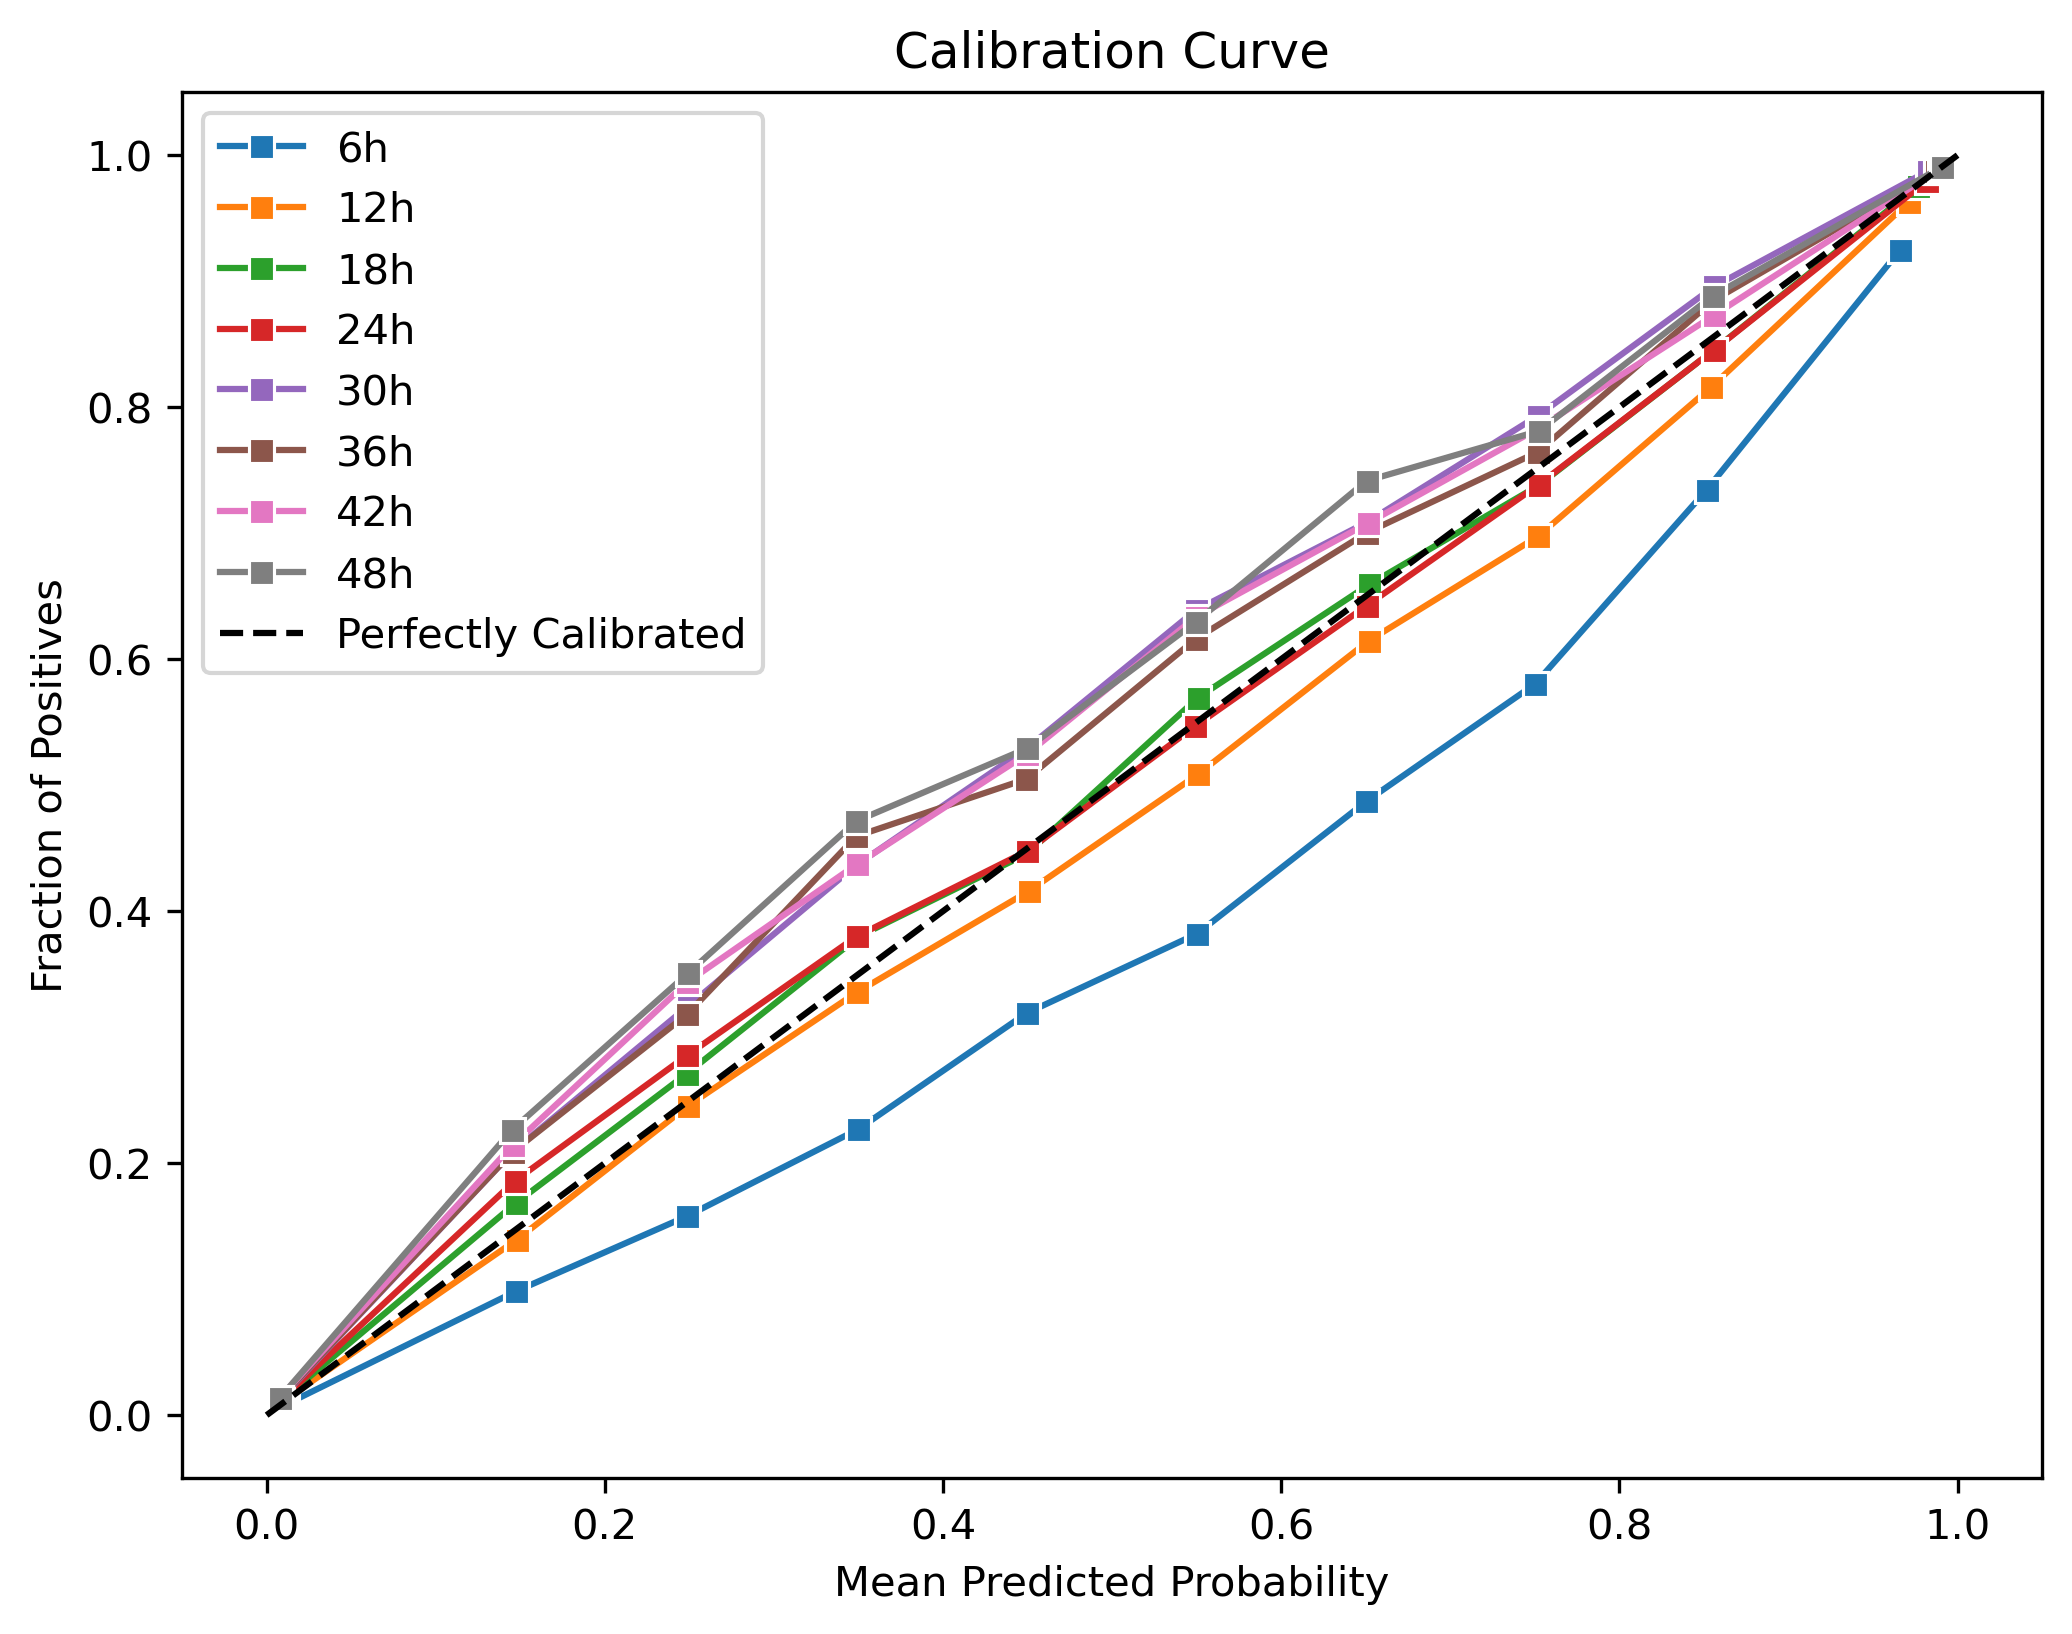

In [7]:
# Main dataloaders
plt.figure(figsize=(8, 6), dpi=300)

main_dataloaders = [
    (main_dataloader_6h, "6h"),
    (main_dataloader_12h, "12h"),
    (main_dataloader_18h, "18h"),
    (main_dataloader_24h, "24h"),
    (main_dataloader_30h, "30h"),
    (main_dataloader_36h, "36h"),
    (main_dataloader_42h, "42h"),
    (main_dataloader_48h, "48h"),
]

for dataloader, label in main_dataloaders:
    y_true, y_scores = module.step_ROC(dataloader)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_scores, n_bins=10)
    sns.lineplot(x=mean_predicted_value, y=fraction_of_positives, marker='s', label=label)

plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend(loc='upper left')
plt.show()

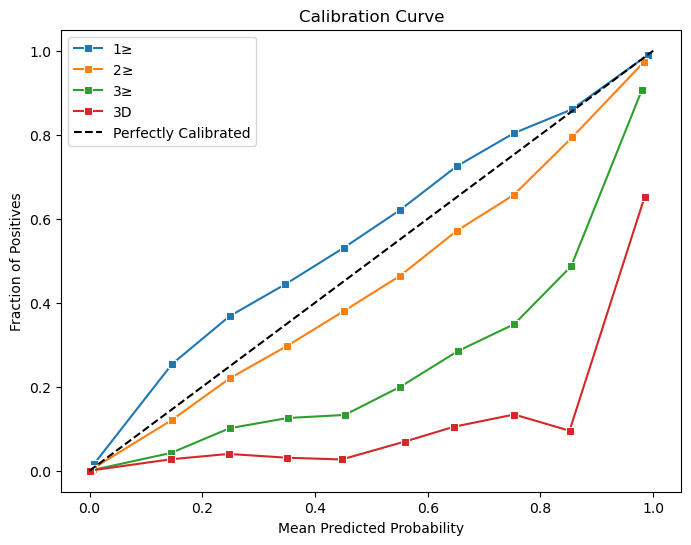

In [8]:
# Sub dataloaders
plt.figure(figsize=(8, 6))

sub_dataloaders = [
    (sub_dataloader_1, "1≥"),
    (sub_dataloader_2, "2≥"),
    (sub_dataloader_3, "3≥"),
    (sub_dataloader_3D, "3D"),
]

for dataloader, label in sub_dataloaders:
    y_true, y_scores = module.step_ROC(dataloader)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_scores, n_bins=10)
    sns.lineplot(x=mean_predicted_value, y=fraction_of_positives, marker='s', label=label)

plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()

# Calibration

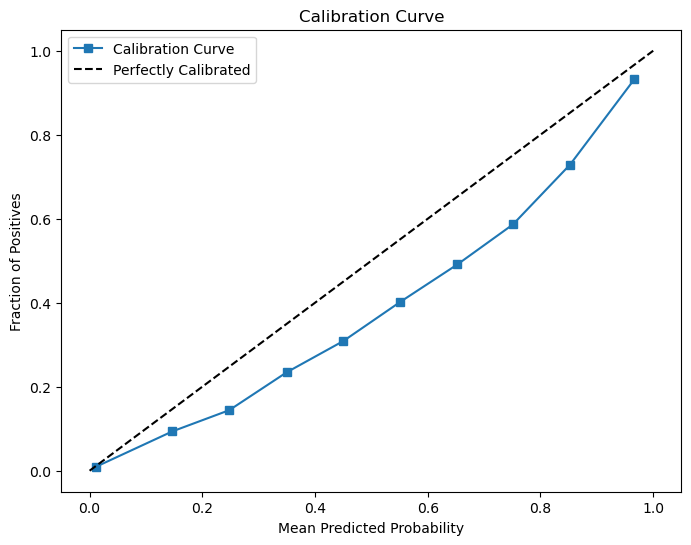

Brier Score Before: 0.0983
Brier Score After: 0.0912
[✓] Calibration improved performance.


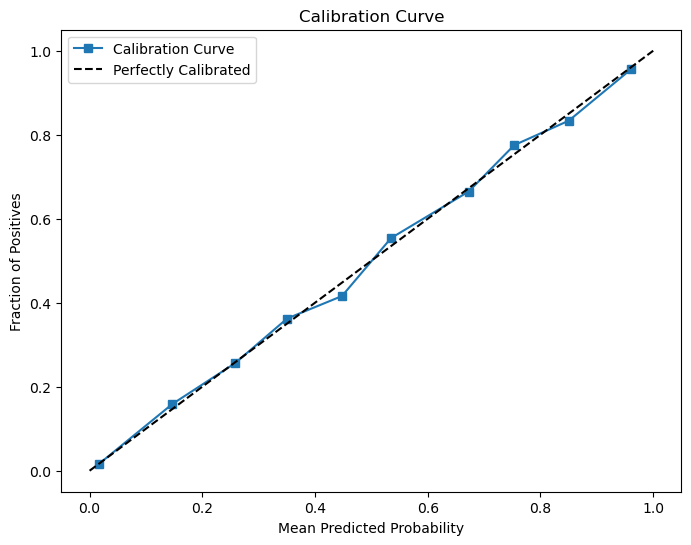

▶ [Main] Result after calibration: 6h
94.2 (94.1-94.4)
88.4 (87.6-88.3)
92.5 (92.3-92.7)
88.4 (87.6-88.3)
90.4 (89.8-91.0)
83.1 (81.3-83.5)


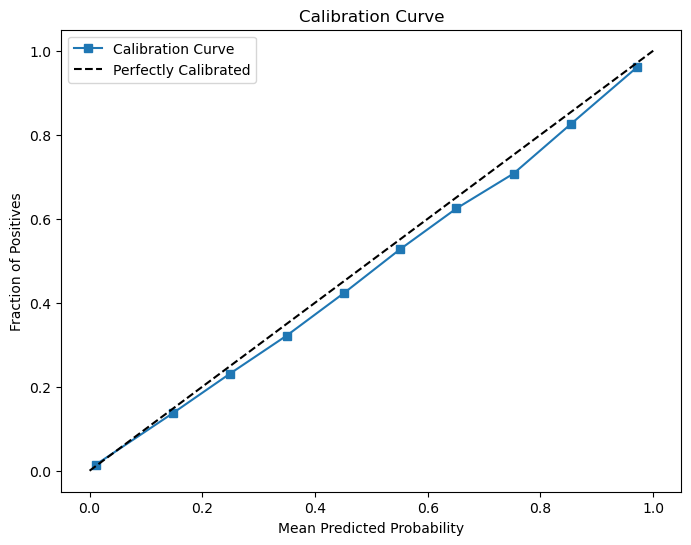

Brier Score Before: 0.0814
Brier Score After: 0.081
[✓] Calibration improved performance.


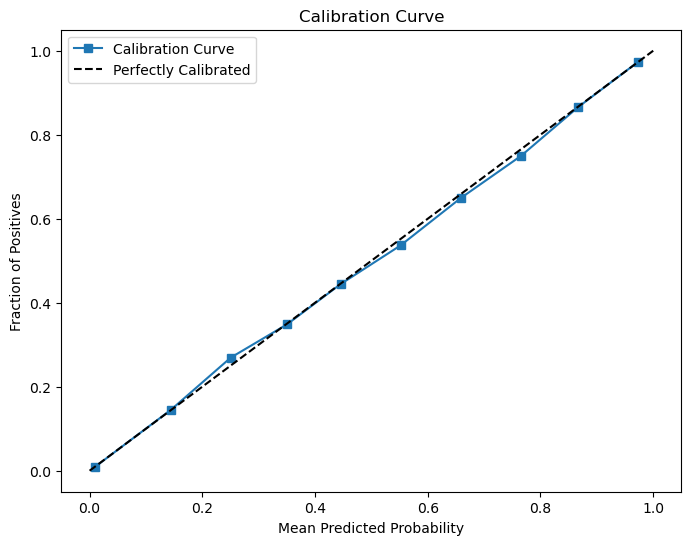

▶ [Main] Result after calibration: 12h
95.8 (95.7-95.9)
94.3 (93.8-94.2)
94.3 (94.1-94.5)
94.3 (93.8-94.2)
90.4 (89.9-91.0)
87.7 (86.3-88.1)


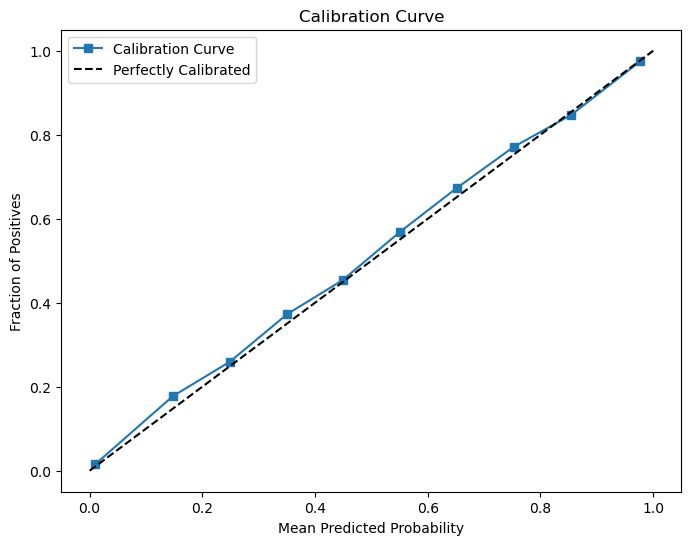

Brier Score Before: 0.067
Brier Score After: 0.0671
[!] Calibration degraded performance. Reverting to original.
▶ [Main] Result after calibration: 18h
97.1 (97.0-97.2)
96.8 (96.7-96.9)
95.9 (95.7-96.0)
96.8 (96.7-96.9)
91.6 (91.1-92.2)
91.8 (91.2-92.4)


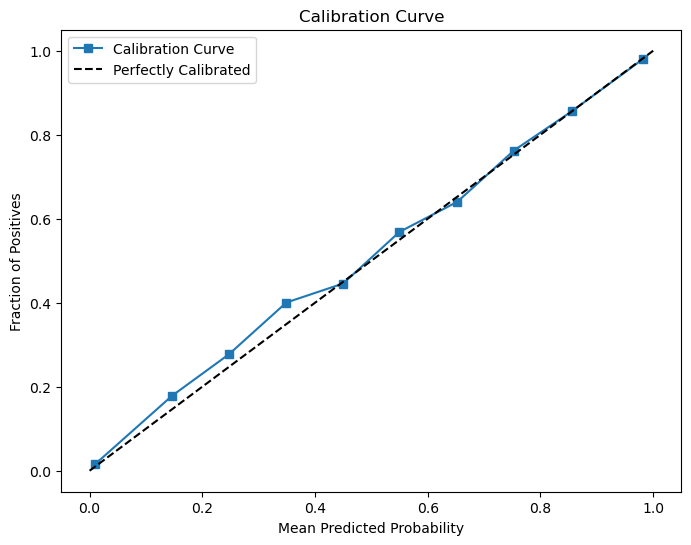

Brier Score Before: 0.0564
Brier Score After: 0.0563
[✓] Calibration improved performance.


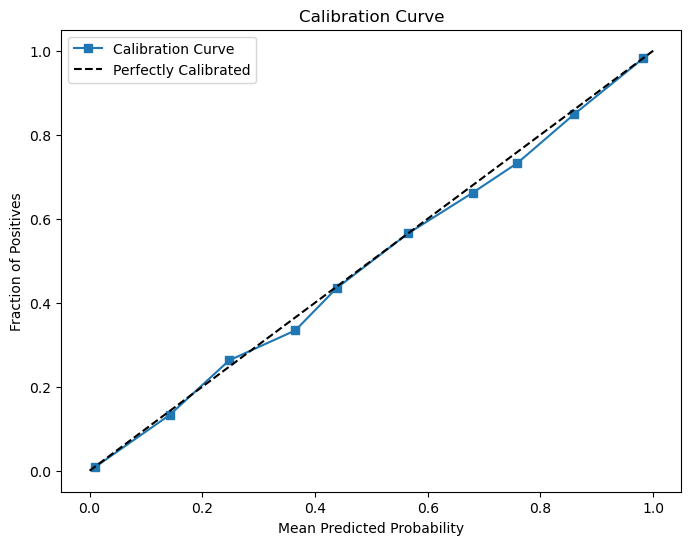

▶ [Main] Result after calibration: 24h
97.9 (97.8-98.0)
98.0 (97.8-98.0)
96.9 (96.8-97.1)
98.1 (97.9-98.0)
92.9 (92.4-93.5)
94.7 (93.9-94.9)


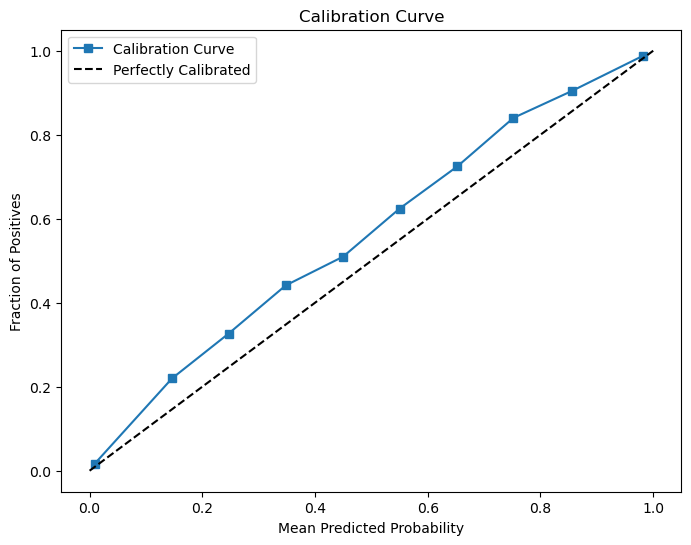

Brier Score Before: 0.0502
Brier Score After: 0.0493
[✓] Calibration improved performance.


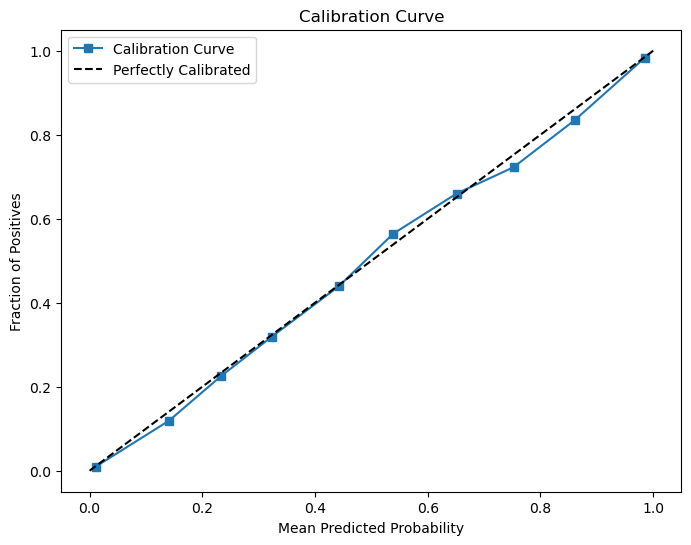

▶ [Main] Result after calibration: 30h
98.4 (98.3-98.4)
98.6 (98.4-98.6)
97.5 (97.4-97.6)
98.6 (98.4-98.6)
93.2 (92.5-93.9)
96.0 (95.3-96.2)


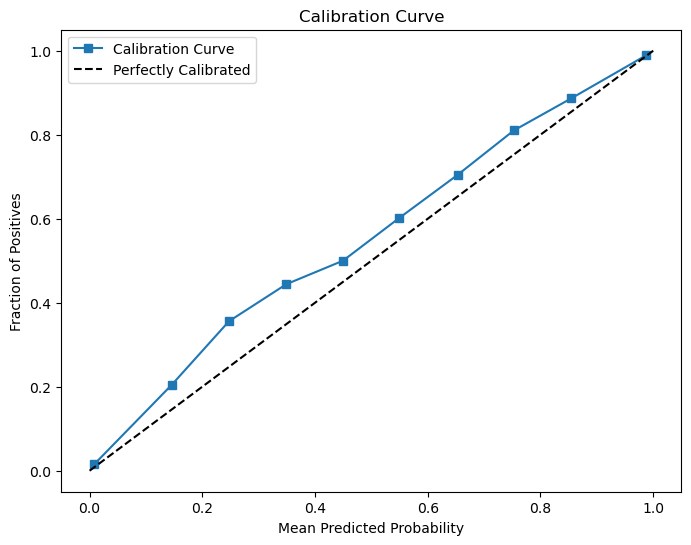

Brier Score Before: 0.044
Brier Score After: 0.0436
[✓] Calibration improved performance.


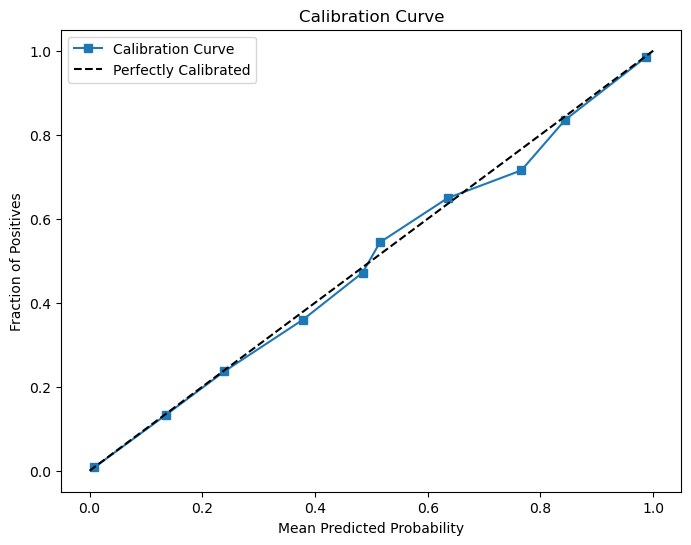

▶ [Main] Result after calibration: 36h
98.7 (98.7-98.8)
99.0 (98.9-99.0)
98.0 (98.0-98.1)
99.0 (98.9-99.0)
94.9 (94.3-95.4)
97.6 (97.2-97.8)


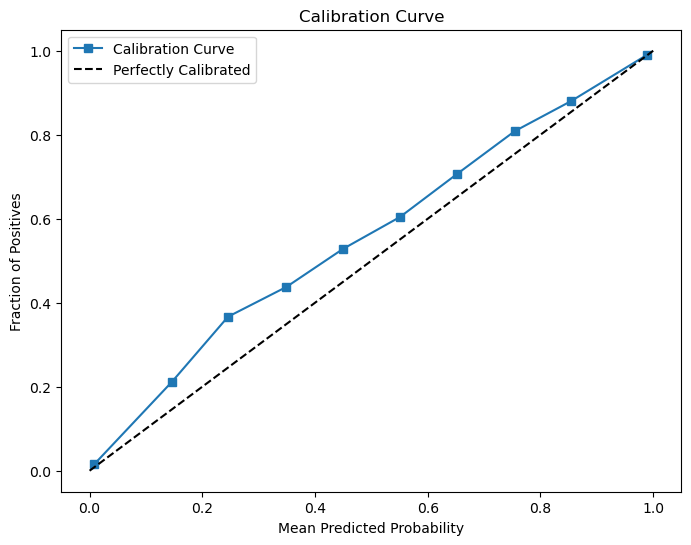

Brier Score Before: 0.0402
Brier Score After: 0.0395
[✓] Calibration improved performance.


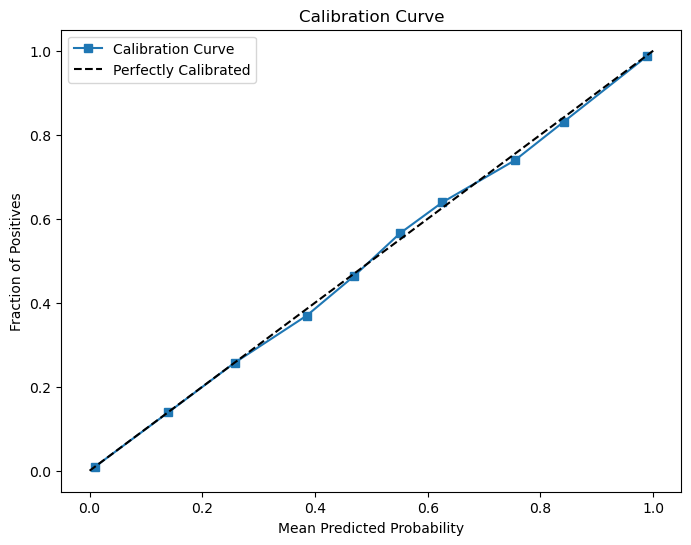

▶ [Main] Result after calibration: 42h
98.9 (98.9-99.0)
99.2 (99.1-99.2)
98.3 (98.3-98.4)
99.2 (99.1-99.2)
95.5 (95.0-95.9)
98.3 (98.0-98.4)


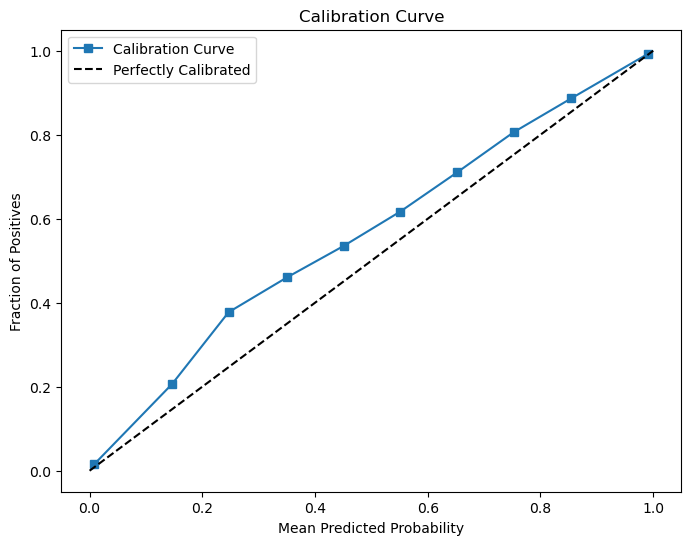

Brier Score Before: 0.0373
Brier Score After: 0.0365
[✓] Calibration improved performance.


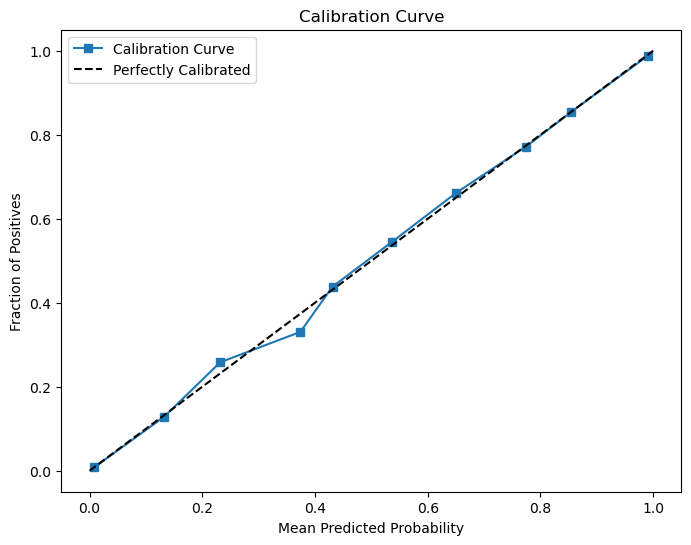

▶ [Main] Result after calibration: 48h
99.1 (99.0-99.1)
99.3 (99.2-99.3)
98.5 (98.5-98.6)
99.3 (99.3-99.3)
95.8 (95.2-96.2)
98.7 (98.4-98.8)


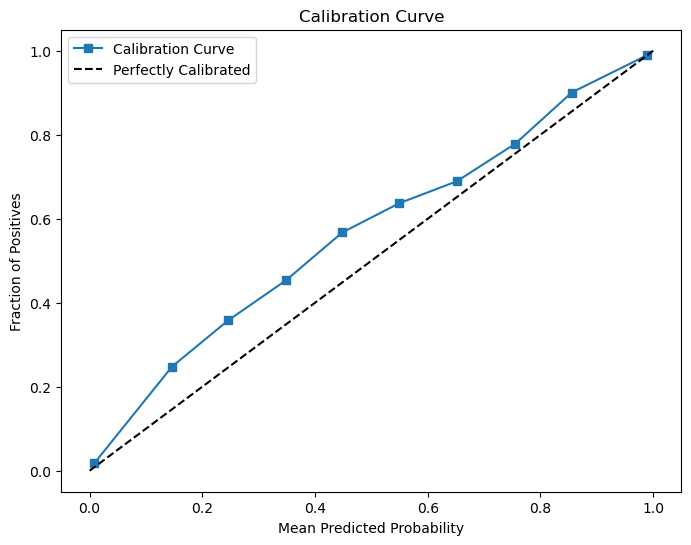

Brier Score Before: 0.0381
Brier Score After: 0.0372
[✓] Calibration improved performance.


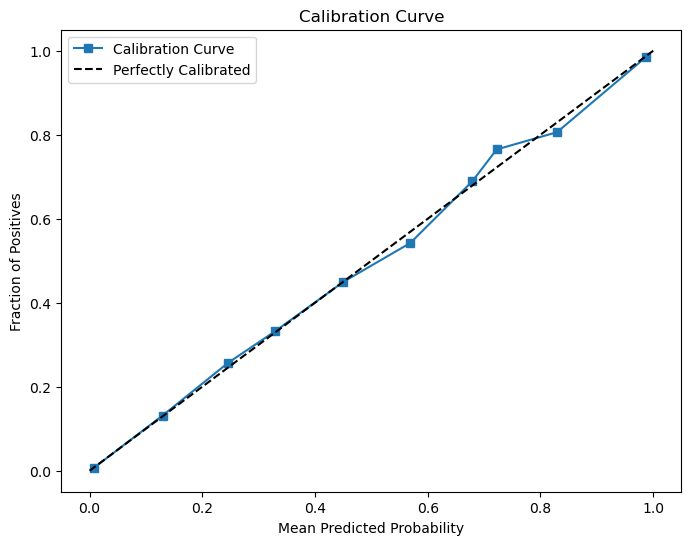

▶ [Sub] Result after calibration: 1≥
99.0 (99.0-99.1)
99.3 (99.2-99.3)
98.5 (98.4-98.5)
99.3 (99.2-99.3)
95.3 (94.7-95.8)
98.6 (98.2-98.7)


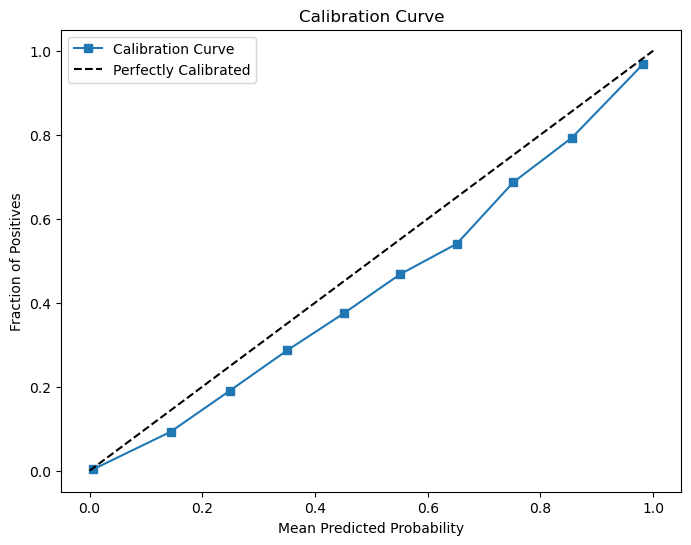

Brier Score Before: 0.0459
Brier Score After: 0.045
[✓] Calibration improved performance.


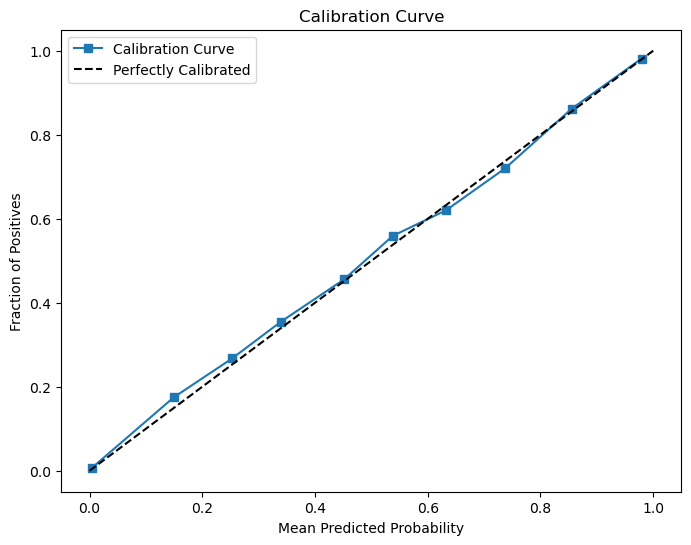

▶ [Sub] Result after calibration: 2≥
98.6 (98.6-98.7)
98.1 (97.9-98.1)
97.3 (97.2-97.4)
98.3 (98.1-98.3)
89.2 (88.5-90.0)
92.4 (91.4-92.6)


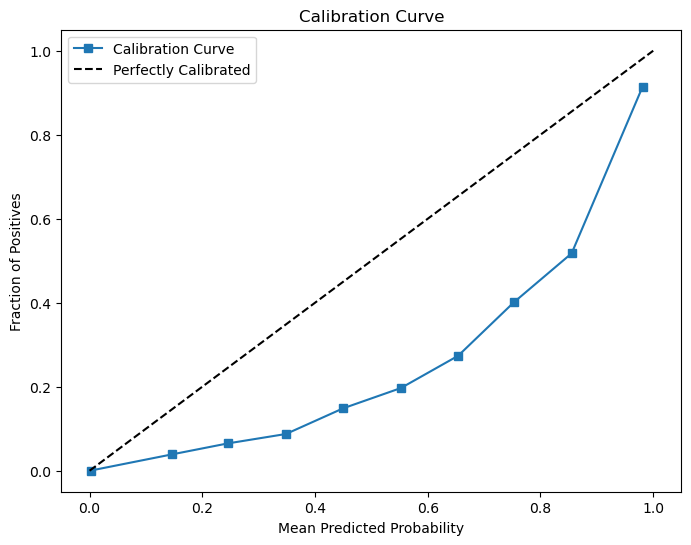

Brier Score Before: 0.0396
Brier Score After: 0.0284
[✓] Calibration improved performance.


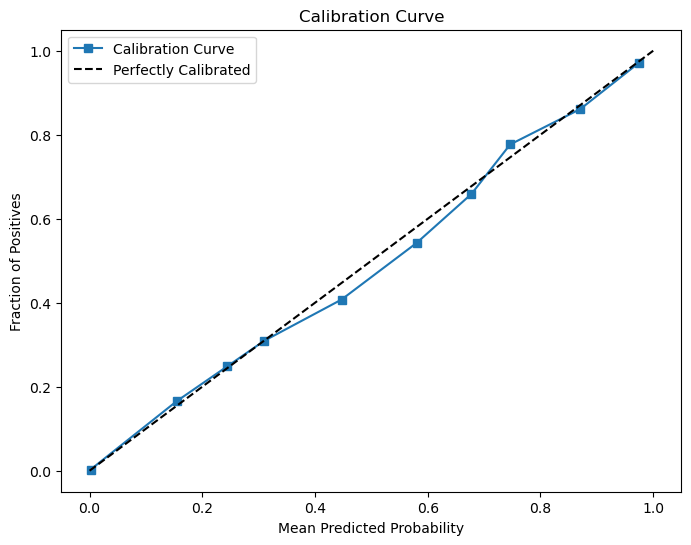

▶ [Sub] Result after calibration: 3≥
99.1 (99.1-99.2)
95.7 (95.2-95.7)
95.9 (95.7-96.1)
96.2 (95.7-96.2)
85.8 (84.5-87.0)
76.5 (73.2-77.7)


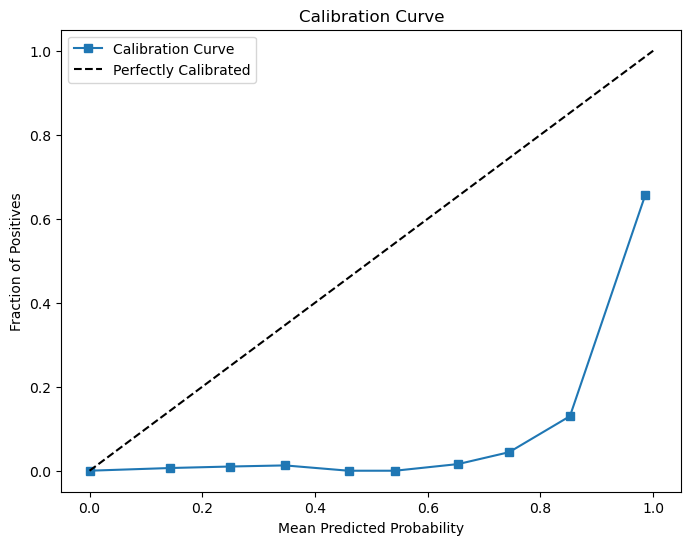

Brier Score Before: 0.0106
Brier Score After: 0.0041
[✓] Calibration improved performance.


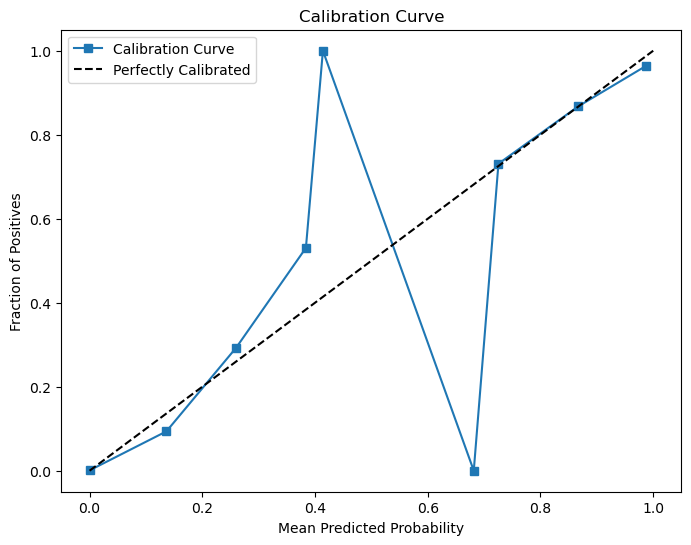

▶ [Sub] Result after calibration: 3D
99.5 (99.3-99.7)
88.2 (84.6-88.3)
97.0 (96.4-97.7)
98.1 (97.1-98.4)
96.2 (94.6-97.4)
87.2 (80.6-91.1)


In [9]:
main_targets = [
    ("6h", main_dataloader_6h_cal, main_dataloader_6h),
    ("12h", main_dataloader_12h_cal, main_dataloader_12h),
    ("18h", main_dataloader_18h_cal, main_dataloader_18h),
    ("24h", main_dataloader_24h_cal, main_dataloader_24h),
    ("30h", main_dataloader_30h_cal, main_dataloader_30h),
    ("36h", main_dataloader_36h_cal, main_dataloader_36h),
    ("42h", main_dataloader_42h_cal, main_dataloader_42h),
    ("48h", main_dataloader_48h_cal, main_dataloader_48h),
]

sub_targets = [
    ("1≥", sub_dataloader_1_cal, sub_dataloader_1),
    ("2≥", sub_dataloader_2_cal, sub_dataloader_2),
    ("3≥", sub_dataloader_3_cal, sub_dataloader_3),
    ("3D", sub_dataloader_3D_cal, sub_dataloader_3D),
]

for label, cal_loader, raw_loader in main_targets:
    calibrated_loader = module.calibration(cal_loader, raw_loader)
    globals()[f"main_dataloader_{label}"] = calibrated_loader
    print(f"▶ [Main] Result after calibration: {label}")
    module.Result(calibrated_loader)

for label, cal_loader, raw_loader in sub_targets:
    key = "sub_dataloader_" + label.replace("≥", "").replace("D", "D")
    calibrated_loader = module.calibration(cal_loader, raw_loader)
    globals()[key] = calibrated_loader
    print(f"▶ [Sub] Result after calibration: {label}")
    module.Result(calibrated_loader)

# Calibration Curve

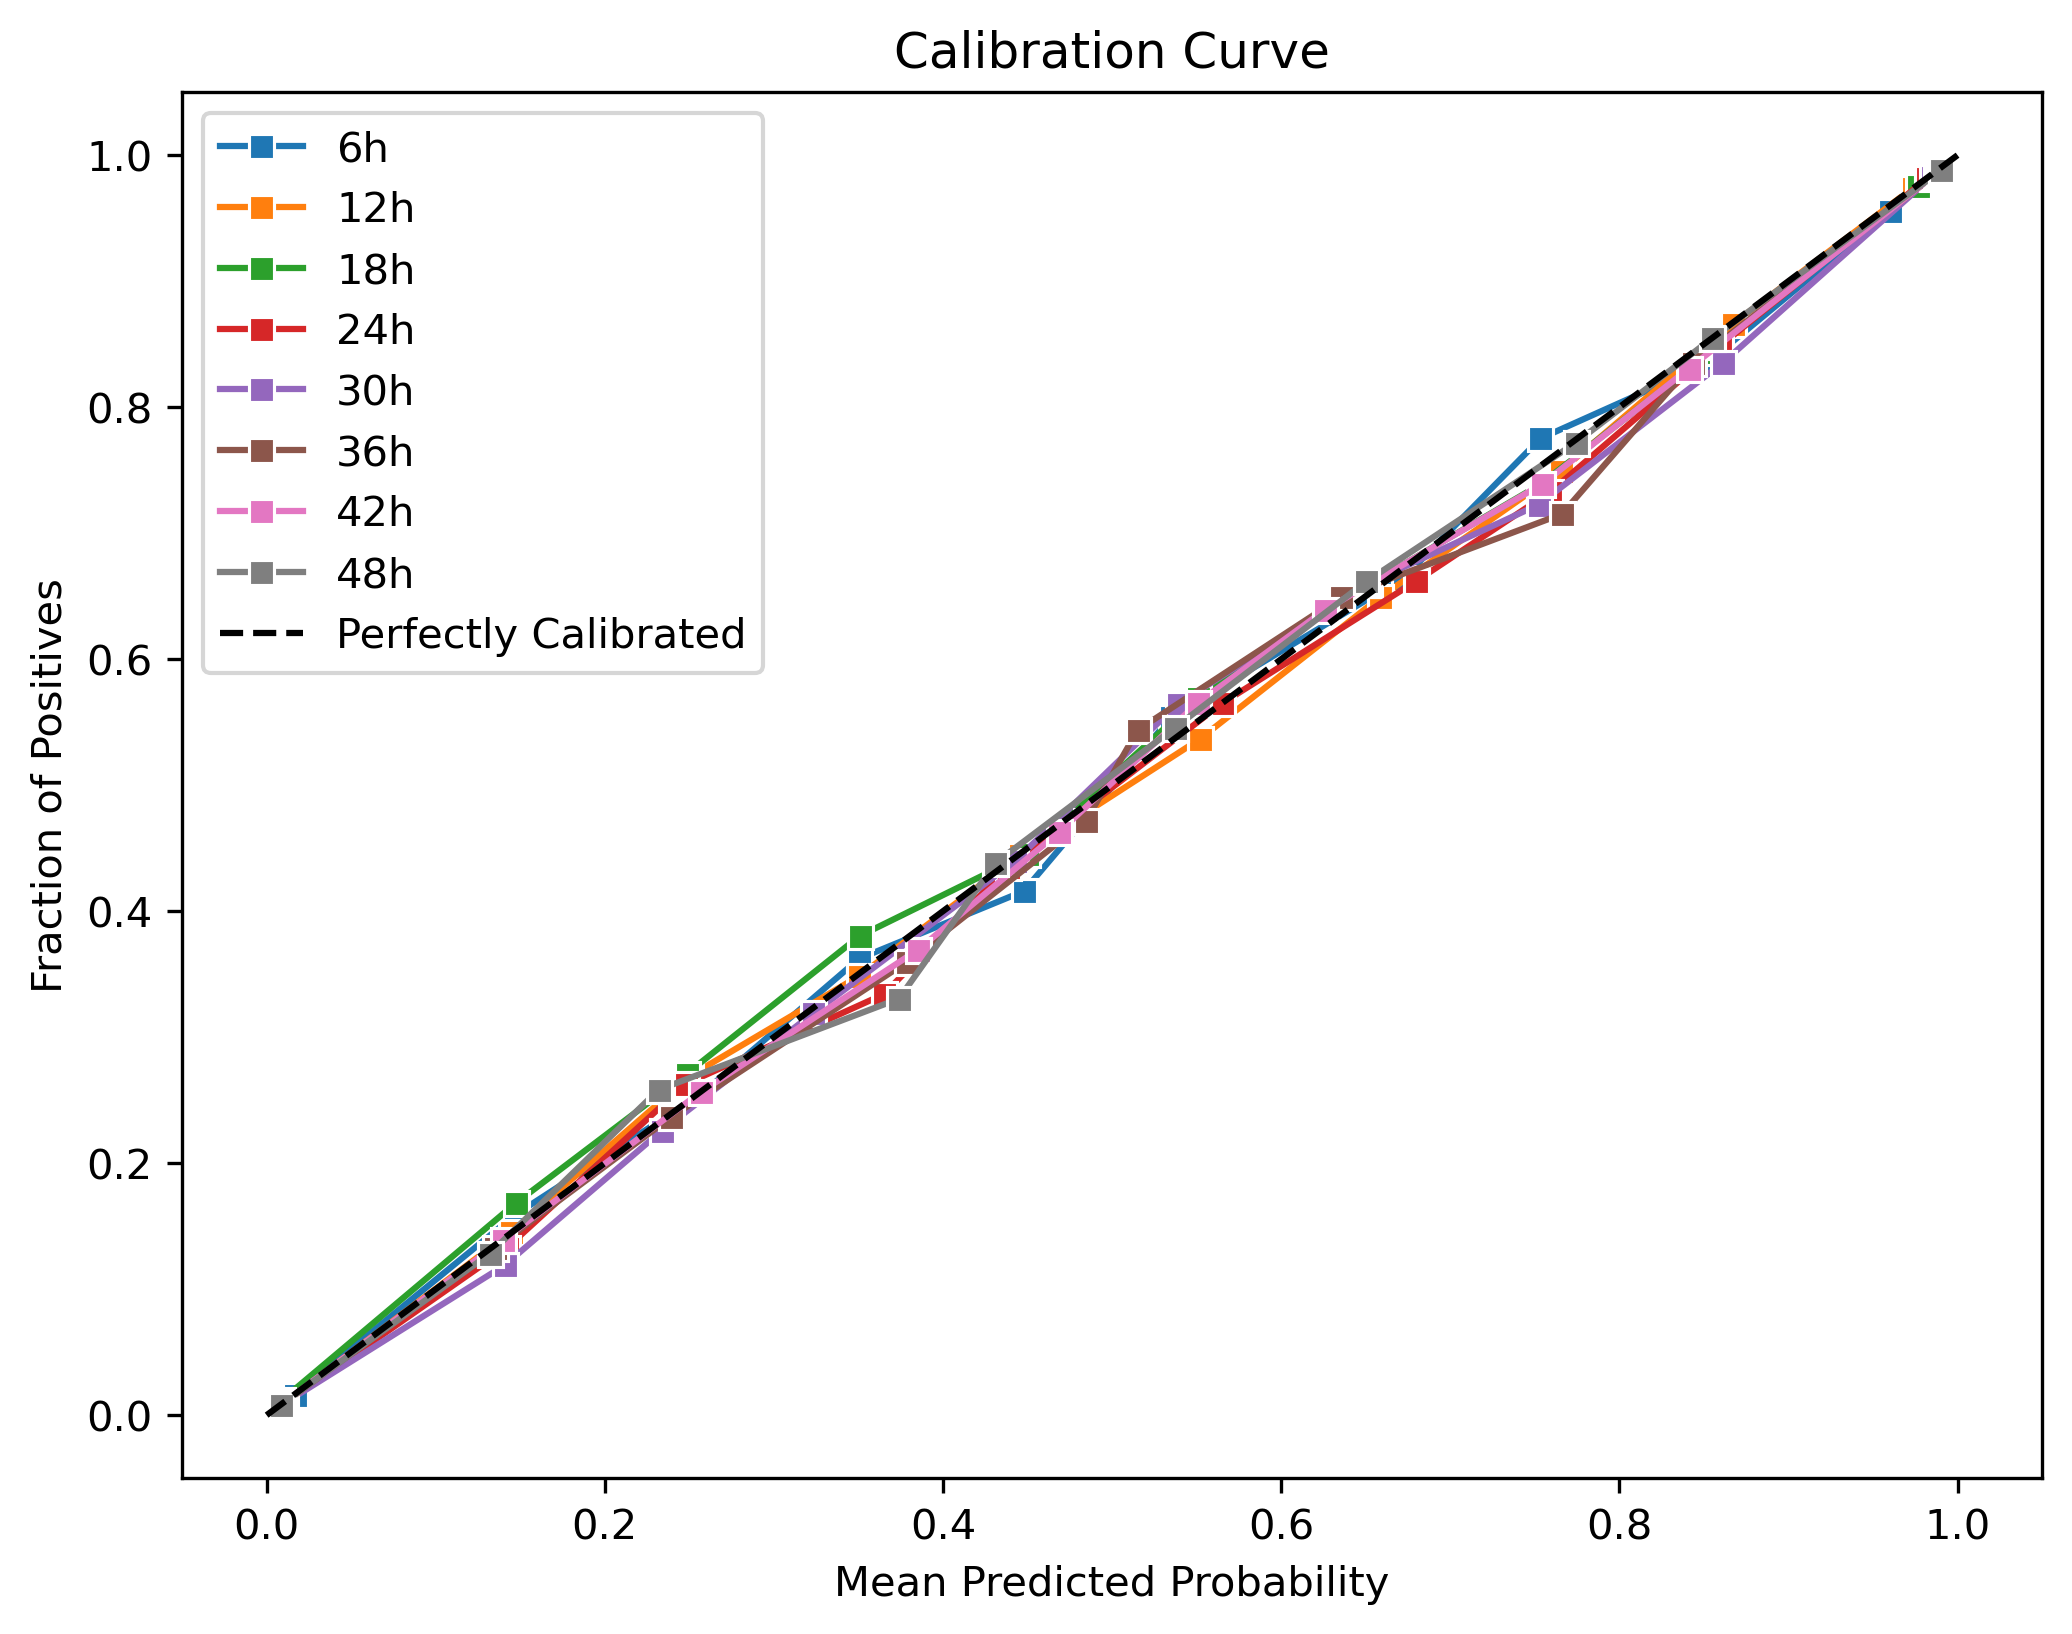

In [10]:
# Main dataloaders
plt.figure(figsize=(8, 6), dpi=300)

main_dataloaders = [
    (main_dataloader_6h, "6h"),
    (main_dataloader_12h, "12h"),
    (main_dataloader_18h, "18h"),
    (main_dataloader_24h, "24h"),
    (main_dataloader_30h, "30h"),
    (main_dataloader_36h, "36h"),
    (main_dataloader_42h, "42h"),
    (main_dataloader_48h, "48h"),
]

for dataloader, label in main_dataloaders:
    y_true, y_scores = module.step_ROC(dataloader)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_scores, n_bins=10)
    sns.lineplot(x=mean_predicted_value, y=fraction_of_positives, marker='s', label=label)

plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend(loc='upper left')
plt.show()

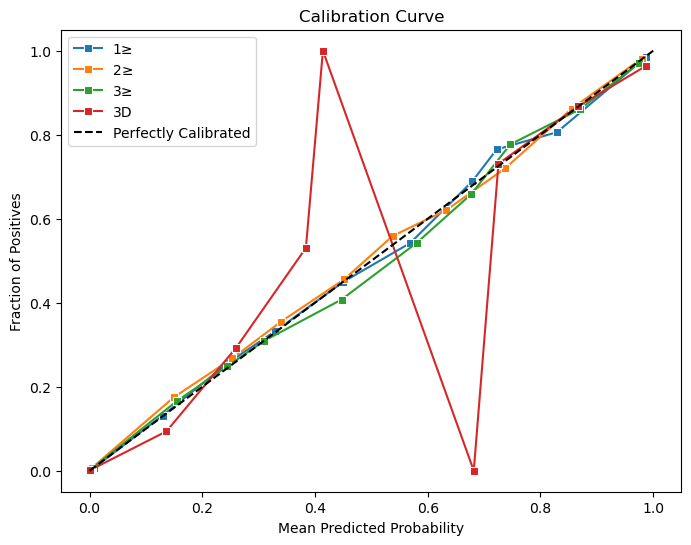

In [11]:
# Sub dataloaders
plt.figure(figsize=(8, 6))

sub_dataloaders = [
    (sub_dataloader_1, "1≥"),
    (sub_dataloader_2, "2≥"),
    (sub_dataloader_3, "3≥"),
    (sub_dataloader_3D, "3D"),
]

for dataloader, label in sub_dataloaders:
    y_true, y_scores = module.step_ROC(dataloader)
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_scores, n_bins=10)
    sns.lineplot(x=mean_predicted_value, y=fraction_of_positives, marker='s', label=label)

plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve")
plt.legend()
plt.show()